In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

In [3]:
import fastai
print("fastai: ",fastai.__version__)
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

fastai:  1.0.42
Torch:  1.0.1.post2
Torchvision:  0.2.1
sklearn:  0.20.2
Python:  3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [4]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [8]:
PATH = '../../../../../data/DogBreeds/'

In [9]:
import os
print(os.listdir(PATH))

['submission2.csv', 'submission101fullTTA.csv', 'submission1.csv', 'train.zip', 'train', 'test.zip', 'test', 'models', 'submissionRN101.csv', 'submission101full.csv', 'labels.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'submission.csv', 'labels.csv']


In [10]:
#print(os.listdir(PATH+'test'))

In [11]:
labels = pd.read_csv(PATH+'labels.csv')
labels.head()


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
labels['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
cairn                             106
leonberg                          106
japanese_spaniel                  105
beagle                            105
blenheim_spaniel                  102
australian_terrier                102
miniature_pinscher                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
norwegian_elkhound                 95
whippet                            95
siberian_husky                     95
pug         

In [13]:
from zipfile import ZipFile
files = os.listdir(PATH)
if not 'train.zip' in files:
    !kaggle competitions download -c dog-breed-identification -p PATH
if not 'train' in files:    
    for file in files:
        with ZipFile(PATH+file, 'r') as zipF:
            zipF.extractall(path=PATH)
            print(file,': Done')
os.listdir(PATH)        

['submission2.csv',
 'submission101fullTTA.csv',
 'submission1.csv',
 'train.zip',
 'train',
 'test.zip',
 'test',
 'models',
 'submissionRN101.csv',
 'submission101full.csv',
 'labels.csv.zip',
 'sample_submission.csv.zip',
 'sample_submission.csv',
 'submission.csv',
 'labels.csv']

In [14]:
path_img = PATH + 'train'
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../../../../../data/DogBreeds/train/c8c1b76b12acf31fbaef3b420099391e.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/1a8a76a7bcc83f2ec151c83753945ac0.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/9eb927fcd2caba4b3d0dfc193a1dfbb4.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/a669f4da695562c34d6498cf1bc92066.jpg'),
 PosixPath('../../../../../data/DogBreeds/train/a6eb4c19bbe8efd5d4fc9ac41e0cba4b.jpg')]

In [15]:
# read image size
im=array([list(open_image(image).size) for image in fnames])

In [16]:
type(im), im.shape, im

(numpy.ndarray, (10222, 2), array([[500, 334],
        [333, 500],
        [492, 428],
        [333, 500],
        ...,
        [375, 500],
        [225, 300],
        [333, 500],
        [375, 500]]))

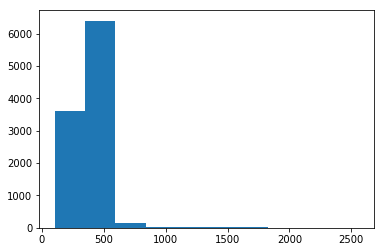

In [17]:
# histogram of x
plt.hist(im[:,0]);

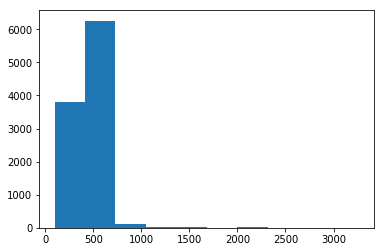

In [18]:
# histogram of y
plt.hist(im[:,1]);

In [19]:
tfms = get_transforms(do_flip=True)

In [20]:
#view image augmentations
def get_ex(): return open_image(fnames[1])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
     rows,cols,figsize=(width,height))[1].flatten())]

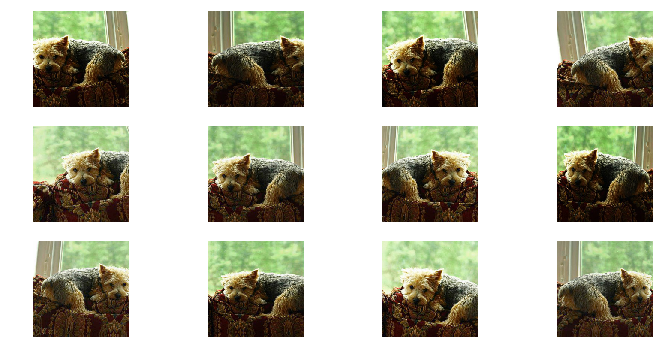

In [21]:
plots_f(3, 4, 12, 6, size=224)

In [22]:
data = ImageDataBunch.from_csv(PATH, folder='train',test='test',csv_labels='labels.csv', ds_tfms=tfms, size=224,suffix='.jpg', bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (8178 items)
[Category boston_bull, Category pekinese, Category bedlington_terrier, Category borzoi, Category basenji]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (8178 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 470, 500), Image (3, 227, 231), Image (3, 500, 474)]...
Path: ../../../../../data/DogBreeds;

Valid: LabelList
y: CategoryList (2044 items)
[Category appenzeller, Category miniature_schnauzer, Category lhasa, Category borzoi, Category norwich_terrier]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (2044 items)
[Image (3, 375, 500), Image (3, 333, 500), Image (3, 200, 200), Image (3, 357, 500), Image (3, 411, 500)]...
Path: ../../../../../data/DogBreeds;

Test: LabelList
y: EmptyLabelList (10357 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (10357 items)
[Image (3, 333, 500), Image (3, 500, 333), Image (3, 225, 300), Image (3, 375, 500), 

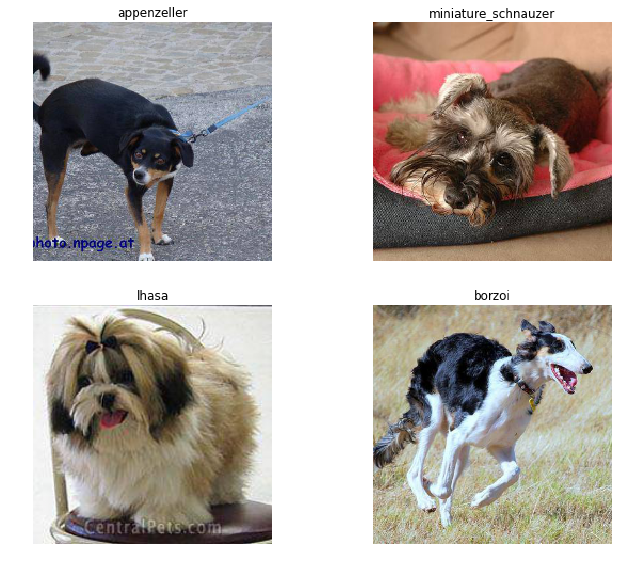

In [23]:
data.show_batch(rows=2, figsize=(10,8), ds_type=DatasetType.Valid)

In [24]:
print(data.classes)
len(data.classes)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

120

In [25]:
learn = create_cnn(data, models.resnet101, metrics=error_rate)
#learn.interpret(tta=True)


In [26]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

## Training the Model

In [27]:
#learn.freeze()
#learn.lr_find(start_lr=1e-8)
#learn.recorder.plot()

In [28]:
# Run first fit with frozen layers
learn.fit_one_cycle(5)
# 1	1.167033	0.682278	0.213307
# 2	0.971831	0.573867	0.175636
# 3	0.796868	0.490537	0.149706
# 4	0.496800	0.420384	0.124266
# 5	0.456235	0.394118	0.122798


epoch,train_loss,valid_loss,error_rate
1,1.234464,0.639825,0.189824
2,0.983970,0.528542,0.168787
3,0.807440,0.438532,0.129159
4,0.569582,0.383631,0.114971
5,0.415527,0.368492,0.110568


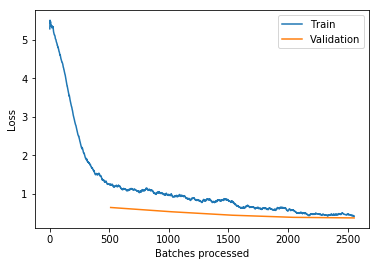

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('224_pre')

In [31]:
#learn.load('224_pre');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


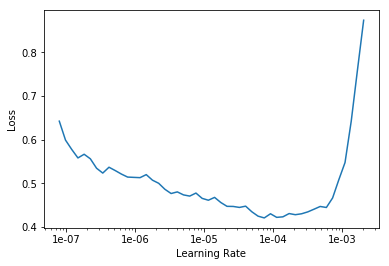

In [32]:
learn.unfreeze()
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(5, max_lr=slice(1e-7,1e-6))

# 1	0.394906	0.394632	0.124266
# 2	0.397489	0.389986	0.116438
# 3	0.392547	0.387058	0.118885
# 4	0.402625	0.392398	0.120352
# 5	0.396275	0.387107	0.115949

epoch,train_loss,valid_loss,error_rate
1,0.393213,0.375274,0.113992
2,0.437676,0.369187,0.112035
3,0.425174,0.372914,0.107143
4,0.419454,0.363936,0.110078
5,0.375762,0.368741,0.112035


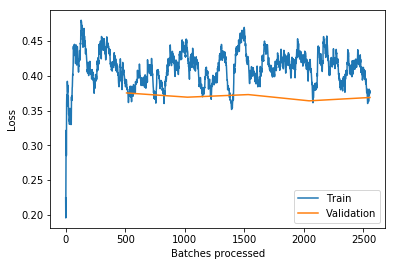

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save('224_all')

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

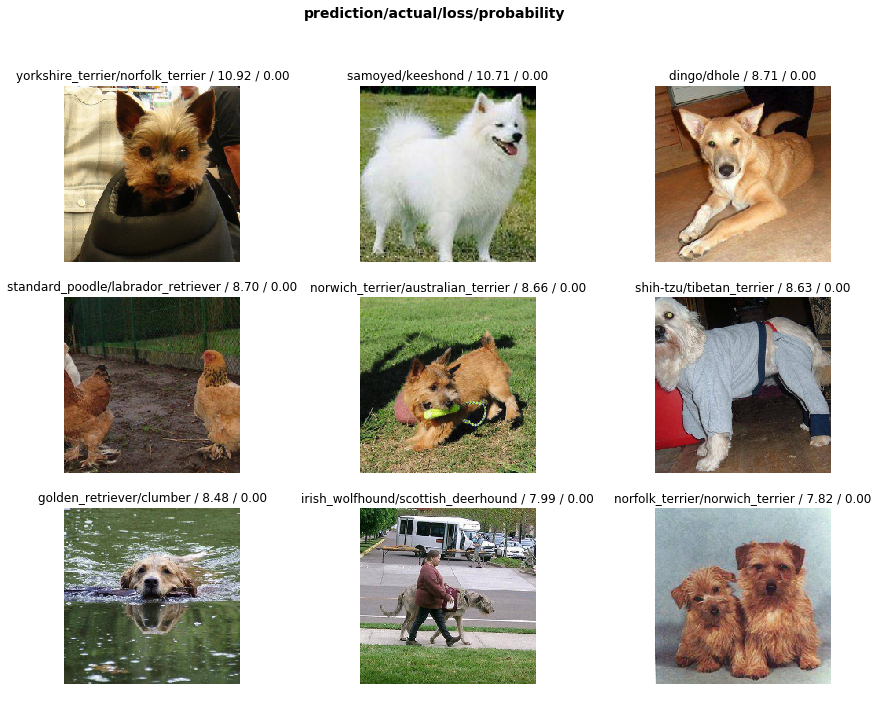

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

In [38]:
interp.most_confused(min_val=2)

[('american_staffordshire_terrier', 'staffordshire_bullterrier', 8),
 ('eskimo_dog', 'siberian_husky', 7),
 ('irish_wolfhound', 'scottish_deerhound', 5),
 ('norwich_terrier', 'norfolk_terrier', 5),
 ('standard_schnauzer', 'miniature_schnauzer', 5),
 ('walker_hound', 'english_foxhound', 5),
 ('collie', 'border_collie', 4),
 ('eskimo_dog', 'malamute', 4),
 ('silky_terrier', 'australian_terrier', 4),
 ('english_foxhound', 'beagle', 3),
 ('kuvasz', 'great_pyrenees', 3),
 ('miniature_poodle', 'standard_poodle', 3),
 ('norfolk_terrier', 'norwich_terrier', 3),
 ('pomeranian', 'samoyed', 3),
 ('scottish_deerhound', 'irish_wolfhound', 3),
 ('shih-tzu', 'lhasa', 3),
 ('silky_terrier', 'yorkshire_terrier', 3),
 ('tibetan_terrier', 'shih-tzu', 3),
 ('wire-haired_fox_terrier', 'lakeland_terrier', 3)]

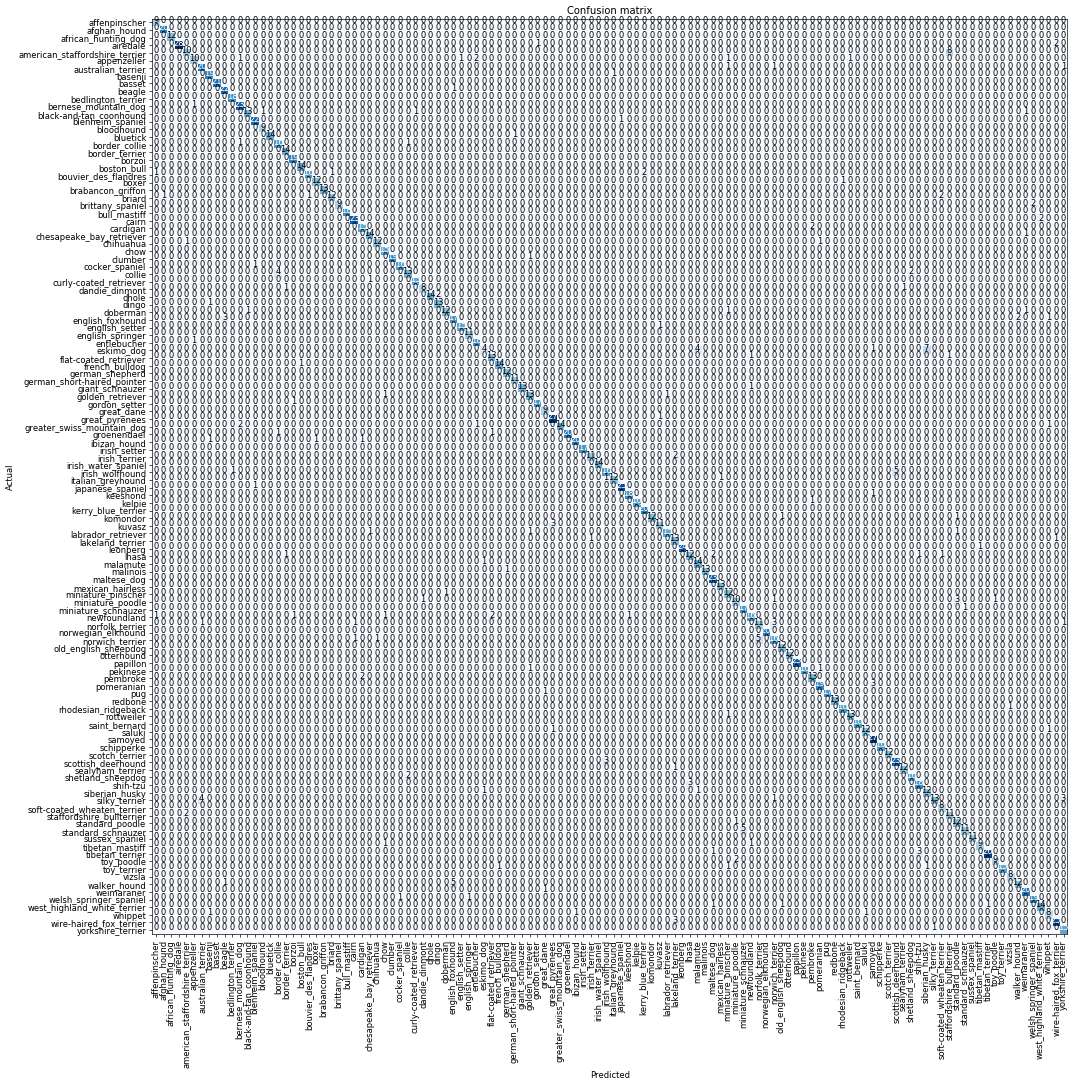

In [39]:
interp.plot_confusion_matrix(figsize=(18,18), dpi=60)

In [40]:
# Increase image size to 299
size = 299

In [41]:
data = ImageDataBunch.from_csv(PATH, folder='train',test='test',csv_labels='labels.csv', ds_tfms=tfms, size=size,suffix='.jpg', bs=32)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (8178 items)
[Category boston_bull, Category dingo, Category pekinese, Category bluetick, Category golden_retriever]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (8178 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 344, 400), Image (3, 500, 500)]...
Path: ../../../../../data/DogBreeds;

Valid: LabelList
y: CategoryList (2044 items)
[Category pomeranian, Category keeshond, Category afghan_hound, Category italian_greyhound, Category curly-coated_retriever]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (2044 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 500, 386), Image (3, 375, 500), Image (3, 191, 283)]...
Path: ../../../../../data/DogBreeds;

Test: LabelList
y: EmptyLabelList (10357 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (10357 items)
[Image (3, 333, 500), Image (3, 500, 333), Image (3, 225, 300), Image (3, 

In [42]:
learn.load('224_all')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (8178 items)
[Category boston_bull, Category pekinese, Category bedlington_terrier, Category borzoi, Category basenji]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (8178 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 470, 500), Image (3, 227, 231), Image (3, 500, 474)]...
Path: ../../../../../data/DogBreeds;

Valid: LabelList
y: CategoryList (2044 items)
[Category appenzeller, Category miniature_schnauzer, Category lhasa, Category borzoi, Category norwich_terrier]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (2044 items)
[Image (3, 375, 500), Image (3, 333, 500), Image (3, 200, 200), Image (3, 357, 500), Image (3, 411, 500)]...
Path: ../../../../../data/DogBreeds;

Test: LabelList
y: EmptyLabelList (10357 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (10357 items)
[Image (3, 333, 500), Image (3, 500, 333), Image (3, 225, 300), Image (3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


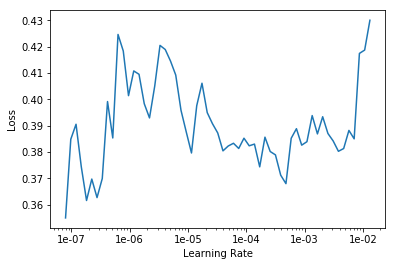

In [43]:
learn.freeze()
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, max_lr=1e-4)
# 1	0.387963	0.385639	0.119863
# 2	0.413568	0.380983	0.115460
# 3	0.366125	0.375542	0.117417
# 4	0.334128	0.384973	0.120352
# 5	0.351631	0.379442	0.118885

epoch,train_loss,valid_loss,error_rate
1,0.445237,0.372635,0.113014
2,0.442279,0.362386,0.113992
3,0.411092,0.362776,0.113503
4,0.383876,0.360714,0.111057
5,0.381579,0.358325,0.110078


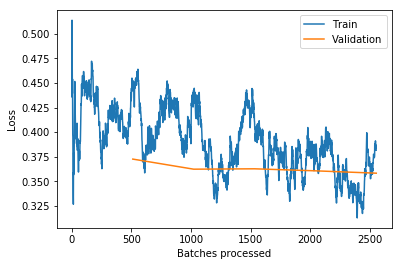

In [45]:
learn.recorder.plot_losses()

In [46]:
learn.save('299_pre')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


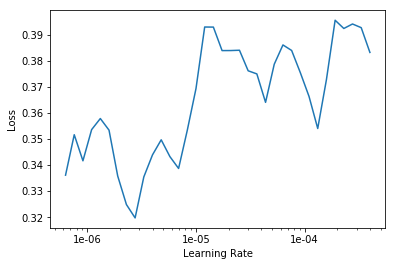

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(6, max_lr=slice(1e-7,2e-6))

epoch,train_loss,valid_loss,error_rate
1,0.331080,0.363444,0.109100
2,0.377482,0.360917,0.111057
3,0.363401,0.359797,0.111546
4,0.403001,0.360013,0.109100
5,0.343893,0.357081,0.113503
6,0.355963,0.361325,0.110568


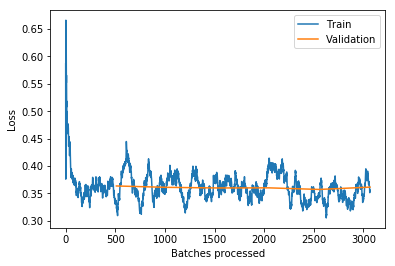

In [49]:
#Resnet101, 0.244996	0.335795	0.104207
learn.recorder.plot_losses()

In [50]:
learn.save('299_all')

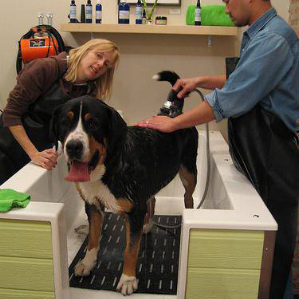

In [51]:
dogNr=9
data.test_ds[dogNr][0]

In [52]:
b = learn.predict(data.test_ds[dogNr][0])
print(b[0])

greater_swiss_mountain_dog


In [53]:
sample_submission_df = pd.read_csv(PATH+'sample_submission.csv')
sample_submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [54]:
log_preds, y = learn.TTA(ds_type=DatasetType.Test) # use test dataset rather than validation dataset

In [55]:
df = pd.DataFrame(log_preds.numpy())
df.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000592,4.712015e-04,9.643063e-04,6.630862e-06,5.331897e-05,4.010878e-04,0.000046,4.796846e-05,3.848689e-05,6.713142e-05,...,0.000041,0.000147,0.000027,3.495234e-04,0.000148,5.930919e-03,3.221193e-04,3.752360e-05,1.286601e-04,0.000050
1,0.000115,5.807771e-07,1.508237e-05,1.372875e-06,2.382567e-07,1.528172e-06,0.006712,8.442726e-07,1.147404e-07,4.376140e-07,...,0.000005,0.001700,0.000004,8.593085e-08,0.000001,4.580244e-06,2.587286e-06,7.368351e-08,2.092009e-05,0.917190
2,0.000317,1.413938e-06,2.998734e-06,1.038767e-04,4.436624e-06,1.145910e-04,0.000003,5.787971e-06,2.184423e-05,3.999831e-05,...,0.000027,0.000004,0.000048,5.610452e-05,0.000034,3.531367e-06,1.768795e-06,2.276325e-06,1.164918e-05,0.000001
3,0.000312,5.902464e-06,3.567355e-07,4.995582e-08,1.661743e-06,4.175335e-08,0.000002,1.948781e-07,5.189477e-06,1.032630e-06,...,0.000004,0.000004,0.000003,1.210097e-06,0.000001,2.762098e-08,5.438504e-07,2.103827e-07,3.454044e-07,0.000021
4,0.002315,5.949385e-04,6.230103e-04,4.589716e-04,2.981699e-04,6.023112e-05,0.000335,1.088143e-04,4.548380e-03,2.880728e-03,...,0.000468,0.002052,0.001553,3.263806e-04,0.001287,8.435141e-01,1.004898e-03,1.628826e-04,2.112816e-03,0.003151


In [56]:
#list first few prediction classes
df.idxmax(axis=1).head()

0     41
1    119
2     69
3     70
4    115
dtype: int64

In [57]:
#get test file names
test_img = PATH + 'test'
tnames = get_image_files(test_img)
tnames[:5]


[PosixPath('../../../../../data/DogBreeds/test/5bad43e776606caab0912c9e7f0e75ff.jpg'),
 PosixPath('../../../../../data/DogBreeds/test/cbb4039e5a16f80c02f3d188f98beaf7.jpg'),
 PosixPath('../../../../../data/DogBreeds/test/9ec1a5f9aacbab57bfe9cfa56db788c5.jpg'),
 PosixPath('../../../../../data/DogBreeds/test/8df9fb55617c9eb271087d1eda85a618.jpg'),
 PosixPath('../../../../../data/DogBreeds/test/075c02a433329d00eb726434d8431efd.jpg')]

In [58]:
test_files = os.listdir(PATH+'test')
print(test_files[:5])
len(test_files), type(test_files)

['5bad43e776606caab0912c9e7f0e75ff.jpg', 'cbb4039e5a16f80c02f3d188f98beaf7.jpg', '9ec1a5f9aacbab57bfe9cfa56db788c5.jpg', '8df9fb55617c9eb271087d1eda85a618.jpg', '075c02a433329d00eb726434d8431efd.jpg']


(10357, list)

In [59]:
data.test_ds.x

ImageItemList (10357 items)
[Image (3, 333, 500), Image (3, 500, 333), Image (3, 225, 300), Image (3, 375, 500), Image (3, 334, 500)]...
Path: ../../../../../data/DogBreeds

In [60]:
#add class labels to data frame
df.columns = data.classes
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000592,4.712015e-04,9.643063e-04,6.630862e-06,5.331897e-05,4.010878e-04,0.000046,4.796846e-05,3.848689e-05,6.713142e-05,...,0.000041,0.000147,0.000027,3.495234e-04,0.000148,5.930919e-03,3.221193e-04,3.752360e-05,1.286601e-04,0.000050
1,0.000115,5.807771e-07,1.508237e-05,1.372875e-06,2.382567e-07,1.528172e-06,0.006712,8.442726e-07,1.147404e-07,4.376140e-07,...,0.000005,0.001700,0.000004,8.593085e-08,0.000001,4.580244e-06,2.587286e-06,7.368351e-08,2.092009e-05,0.917190
2,0.000317,1.413938e-06,2.998734e-06,1.038767e-04,4.436624e-06,1.145910e-04,0.000003,5.787971e-06,2.184423e-05,3.999831e-05,...,0.000027,0.000004,0.000048,5.610452e-05,0.000034,3.531367e-06,1.768795e-06,2.276325e-06,1.164918e-05,0.000001
3,0.000312,5.902464e-06,3.567355e-07,4.995582e-08,1.661743e-06,4.175335e-08,0.000002,1.948781e-07,5.189477e-06,1.032630e-06,...,0.000004,0.000004,0.000003,1.210097e-06,0.000001,2.762098e-08,5.438504e-07,2.103827e-07,3.454044e-07,0.000021
4,0.002315,5.949385e-04,6.230103e-04,4.589716e-04,2.981699e-04,6.023112e-05,0.000335,1.088143e-04,4.548380e-03,2.880728e-03,...,0.000468,0.002052,0.001553,3.263806e-04,0.001287,8.435141e-01,1.004898e-03,1.628826e-04,2.112816e-03,0.003151


In [61]:
#insert id by remvoing .jpg from file name
# test_files should also be saved in data.test_ds.x
df.insert(0, "id", [file[:-4] for file in test_files])
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,5bad43e776606caab0912c9e7f0e75ff,0.000592,4.712015e-04,9.643063e-04,6.630862e-06,5.331897e-05,4.010878e-04,0.000046,4.796846e-05,3.848689e-05,...,0.000041,0.000147,0.000027,3.495234e-04,0.000148,5.930919e-03,3.221193e-04,3.752360e-05,1.286601e-04,0.000050
1,cbb4039e5a16f80c02f3d188f98beaf7,0.000115,5.807771e-07,1.508237e-05,1.372875e-06,2.382567e-07,1.528172e-06,0.006712,8.442726e-07,1.147404e-07,...,0.000005,0.001700,0.000004,8.593085e-08,0.000001,4.580244e-06,2.587286e-06,7.368351e-08,2.092009e-05,0.917190
2,9ec1a5f9aacbab57bfe9cfa56db788c5,0.000317,1.413938e-06,2.998734e-06,1.038767e-04,4.436624e-06,1.145910e-04,0.000003,5.787971e-06,2.184423e-05,...,0.000027,0.000004,0.000048,5.610452e-05,0.000034,3.531367e-06,1.768795e-06,2.276325e-06,1.164918e-05,0.000001
3,8df9fb55617c9eb271087d1eda85a618,0.000312,5.902464e-06,3.567355e-07,4.995582e-08,1.661743e-06,4.175335e-08,0.000002,1.948781e-07,5.189477e-06,...,0.000004,0.000004,0.000003,1.210097e-06,0.000001,2.762098e-08,5.438504e-07,2.103827e-07,3.454044e-07,0.000021
4,075c02a433329d00eb726434d8431efd,0.002315,5.949385e-04,6.230103e-04,4.589716e-04,2.981699e-04,6.023112e-05,0.000335,1.088143e-04,4.548380e-03,...,0.000468,0.002052,0.001553,3.263806e-04,0.001287,8.435141e-01,1.004898e-03,1.628826e-04,2.112816e-03,0.003151


In [62]:
df.to_csv(PATH+"submission101fullTTA.csv", index=False)
# Kaggle score 0.39257

## Trying predictions with raw get_preds instead of TTA

In [63]:
# Get Predictions
predictions,y = learn.get_preds(ds_type=DatasetType.Test)


In [64]:
df2 = pd.DataFrame(predictions.numpy())
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.126023e-04,1.133350e-04,2.826431e-04,3.637442e-06,4.204213e-05,5.134055e-04,1.022008e-05,4.863958e-05,2.974057e-05,7.536297e-05,...,2.845098e-05,1.866714e-04,1.324721e-05,2.103807e-04,8.458859e-05,4.211627e-03,2.280360e-04,3.161553e-05,5.369035e-05,3.033011e-05
1,5.512105e-05,2.606415e-07,1.172914e-05,9.672312e-07,6.705110e-08,7.625160e-07,4.012353e-03,1.054327e-06,6.450775e-08,2.066566e-07,...,4.434873e-06,2.408751e-03,2.407497e-06,3.942776e-08,9.199366e-07,3.013555e-06,1.966349e-06,4.286133e-08,1.261785e-05,9.538755e-01
2,7.654521e-08,3.661565e-08,1.633958e-09,1.074349e-09,3.708210e-09,3.288211e-10,2.363419e-10,3.669187e-11,7.691760e-10,1.614697e-09,...,4.930076e-09,6.844257e-11,2.158607e-09,3.014885e-09,5.240098e-09,3.106596e-10,3.648704e-11,4.096054e-11,3.799920e-10,3.354665e-10
3,1.699947e-04,9.748710e-06,3.770153e-07,5.615709e-08,2.276638e-06,6.458983e-08,2.829047e-06,1.758465e-07,4.123036e-06,1.272475e-06,...,2.358533e-06,2.737935e-06,5.443446e-06,1.603390e-06,2.408889e-06,1.865602e-08,1.911113e-07,2.066912e-07,4.430602e-07,1.723891e-05
4,7.859028e-08,3.362818e-06,4.534939e-06,9.702601e-07,9.859664e-07,1.573960e-07,2.343082e-07,3.540231e-06,9.898595e-03,7.574367e-04,...,1.806898e-05,1.593865e-05,5.857003e-07,1.071574e-04,1.968407e-06,9.873196e-01,1.916335e-05,2.074030e-06,3.221120e-05,3.780058e-05


In [65]:
#add class labels to data frame
df2.columns = data.classes
df2.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.126023e-04,1.133350e-04,2.826431e-04,3.637442e-06,4.204213e-05,5.134055e-04,1.022008e-05,4.863958e-05,2.974057e-05,7.536297e-05,...,2.845098e-05,1.866714e-04,1.324721e-05,2.103807e-04,8.458859e-05,4.211627e-03,2.280360e-04,3.161553e-05,5.369035e-05,3.033011e-05
1,5.512105e-05,2.606415e-07,1.172914e-05,9.672312e-07,6.705110e-08,7.625160e-07,4.012353e-03,1.054327e-06,6.450775e-08,2.066566e-07,...,4.434873e-06,2.408751e-03,2.407497e-06,3.942776e-08,9.199366e-07,3.013555e-06,1.966349e-06,4.286133e-08,1.261785e-05,9.538755e-01
2,7.654521e-08,3.661565e-08,1.633958e-09,1.074349e-09,3.708210e-09,3.288211e-10,2.363419e-10,3.669187e-11,7.691760e-10,1.614697e-09,...,4.930076e-09,6.844257e-11,2.158607e-09,3.014885e-09,5.240098e-09,3.106596e-10,3.648704e-11,4.096054e-11,3.799920e-10,3.354665e-10
3,1.699947e-04,9.748710e-06,3.770153e-07,5.615709e-08,2.276638e-06,6.458983e-08,2.829047e-06,1.758465e-07,4.123036e-06,1.272475e-06,...,2.358533e-06,2.737935e-06,5.443446e-06,1.603390e-06,2.408889e-06,1.865602e-08,1.911113e-07,2.066912e-07,4.430602e-07,1.723891e-05
4,7.859028e-08,3.362818e-06,4.534939e-06,9.702601e-07,9.859664e-07,1.573960e-07,2.343082e-07,3.540231e-06,9.898595e-03,7.574367e-04,...,1.806898e-05,1.593865e-05,5.857003e-07,1.071574e-04,1.968407e-06,9.873196e-01,1.916335e-05,2.074030e-06,3.221120e-05,3.780058e-05


In [66]:
#insert id by remvoing .jpg from file name
df2.insert(0, "id", [file[:-4] for file in test_files])
df2.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,5bad43e776606caab0912c9e7f0e75ff,1.126023e-04,1.133350e-04,2.826431e-04,3.637442e-06,4.204213e-05,5.134055e-04,1.022008e-05,4.863958e-05,2.974057e-05,...,2.845098e-05,1.866714e-04,1.324721e-05,2.103807e-04,8.458859e-05,4.211627e-03,2.280360e-04,3.161553e-05,5.369035e-05,3.033011e-05
1,cbb4039e5a16f80c02f3d188f98beaf7,5.512105e-05,2.606415e-07,1.172914e-05,9.672312e-07,6.705110e-08,7.625160e-07,4.012353e-03,1.054327e-06,6.450775e-08,...,4.434873e-06,2.408751e-03,2.407497e-06,3.942776e-08,9.199366e-07,3.013555e-06,1.966349e-06,4.286133e-08,1.261785e-05,9.538755e-01
2,9ec1a5f9aacbab57bfe9cfa56db788c5,7.654521e-08,3.661565e-08,1.633958e-09,1.074349e-09,3.708210e-09,3.288211e-10,2.363419e-10,3.669187e-11,7.691760e-10,...,4.930076e-09,6.844257e-11,2.158607e-09,3.014885e-09,5.240098e-09,3.106596e-10,3.648704e-11,4.096054e-11,3.799920e-10,3.354665e-10
3,8df9fb55617c9eb271087d1eda85a618,1.699947e-04,9.748710e-06,3.770153e-07,5.615709e-08,2.276638e-06,6.458983e-08,2.829047e-06,1.758465e-07,4.123036e-06,...,2.358533e-06,2.737935e-06,5.443446e-06,1.603390e-06,2.408889e-06,1.865602e-08,1.911113e-07,2.066912e-07,4.430602e-07,1.723891e-05
4,075c02a433329d00eb726434d8431efd,7.859028e-08,3.362818e-06,4.534939e-06,9.702601e-07,9.859664e-07,1.573960e-07,2.343082e-07,3.540231e-06,9.898595e-03,...,1.806898e-05,1.593865e-05,5.857003e-07,1.071574e-04,1.968407e-06,9.873196e-01,1.916335e-05,2.074030e-06,3.221120e-05,3.780058e-05


In [67]:
df2.to_csv(PATH+"submission101full.csv", index=False)
# Kaggle score 0.35418

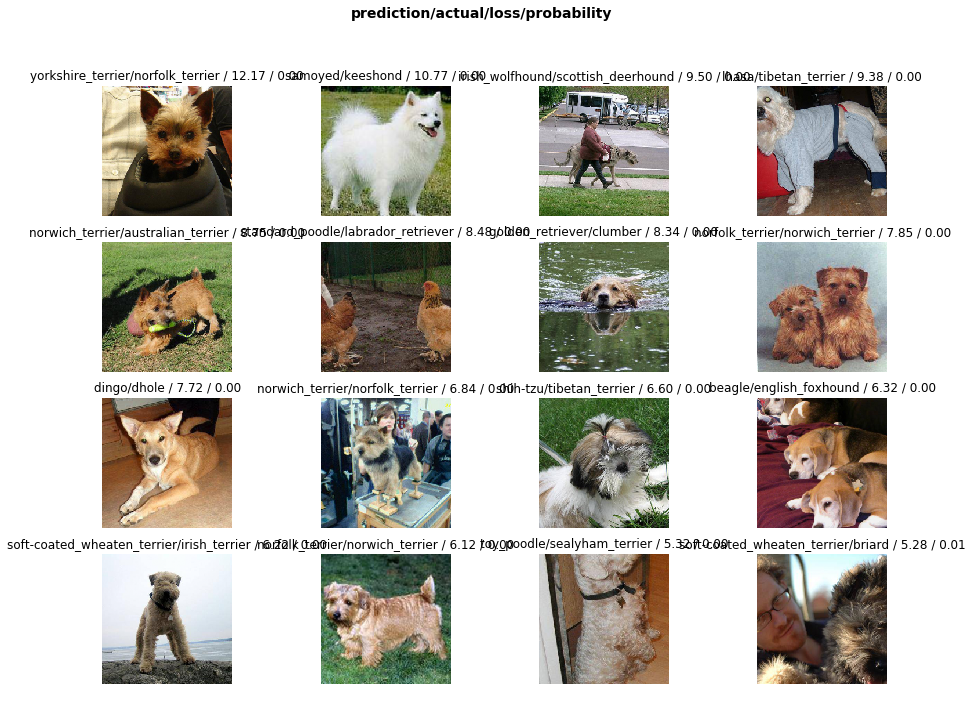

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(16, figsize=(15,11))

In [69]:
doc(ImageDataBunch)